# Lab 4. Konwolucje

Zadanie dla Państwa na te ćwiczenia (z dokończeniem jako praca domowa) to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [2]:
# ploting
%matplotlib inline
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt

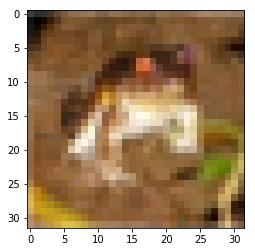

In [3]:
# data loading
cifar_sample = np.load('utils/cifar_sample.npy')
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1,2,0)) 

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważami tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = ??? $  
$ \hspace{140px} H_o = ??? $  
$ \hspace{140px} W_o = ??? $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?  

### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./utils/cnn.gif"></img>

### Zadanie
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazku 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używanie pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który w idea jest podobny do konwolucji, lecz mniej skomplikowany.

### Konwolucja

In [9]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    print('stride : ', stride)
    print('padding: ', padding)
    print('original image shape: ', image.shape)
    print('filters shape: ', filters.shape)
    if padding > 0:
        row_tensor = torch.zeros(3, img_width, padding)
        print('row_tensor shape: ', row_tensor.shape)
        padded_image = torch.cat((row_tensor, image, row_tensor), 2) 
        column_tensor = torch.zeros(3, padding, padded_image.shape[2])
        padded_image = torch.cat((column_tensor, padded_image ,column_tensor), 1) 
        print('padded image shape: ', padded_image.shape)
        print(padded_image[0])
    else:
        padded_image = image
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    out_height = int((img_height - filter_size + 2 * padding) / stride + 1)
    out_width = int((img_width - filter_size + 2 * padding) / stride + 1)
    out_channels = n_filters 
    out = torch.zeros(out_channels, out_height, out_width)
    
    print('out shape: ',out.shape)
    for f_n in range(n_filters):
        print('fn = ',f_n)
        out_r = 0
        for r in range(0, img_height - filter_size + padding * 2 + 1, stride): 
            out_c = 0
            for c in range(0, img_width - filter_size + padding * 2 + 1, stride): 
                out[f_n, out_r, out_c] = torch.sum(filters[f_n] * padded_image[:, r:r+filter_size, c:c+filter_size]) + bias[f_n]
                out_c += 1
            out_r += 1
    return out 

In [15]:
### Convolution Test ### 

from itertools import product
from tqdm import tqdm_notebook as tqdm

# cast the frogi to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
# paddings = [0, 1, 2, 3]
# strides = [1, 2, 3, 4]
# filters = [(torch.randn((2,3,3,3)), torch.zeros((2))),
#            (torch.randn((2,3,5,5)), torch.zeros((2))),
#            (torch.randn((5,3,1,1)), torch.zeros((5)))]
paddings = [0, 1, 2]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.zeros((2))),
           (torch.randn((2,3,5,5)), torch.zeros((2))),
           (torch.randn((5,3,2,2)), torch.zeros((5)))]

# test all combinations
for (filt, bias), stride, padding in tqdm(product(filters, strides, paddings), total=4*4*3):
    # your convolution
    try:
        out = convolution(image, filt, bias, stride=stride, padding=padding)
        print('out.shape = ', out.shape)
        print(out)
        # PyTorch equivalent
        out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
        # asserts
        print('out_torch.shape = ', out_torch.squeeze().shape)
        print(out_torch)
        assert out_torch.squeeze().shape == out.shape
        assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)
    except Exception as e:
        print('error')
        print(e)

stride :  1
padding:  0
original image shape:  torch.Size([3, 32, 32])
filters shape:  torch.Size([2, 3, 3, 3])
out shape:  torch.Size([2, 30, 30])
fn =  0
fn =  1
out.shape =  torch.Size([2, 30, 30])
tensor([[[-0.2272, -0.0796,  0.0902,  ..., -0.1527, -0.3073, -0.2785],
         [ 0.2726,  0.4139,  0.4694,  ..., -0.0051,  0.0297,  0.0955],
         [ 0.3253,  0.4151,  0.2703,  ..., -0.0180, -0.0974, -0.1266],
         ...,
         [ 0.1251,  0.2166,  0.3462,  ..., -0.7147, -0.3314, -0.1668],
         [-0.1523, -0.0978,  0.1517,  ..., -0.5366,  0.3857,  0.6255],
         [-0.2946, -0.2083, -0.0121,  ...,  0.1203,  0.7619,  0.9072]],

        [[ 0.0130, -0.4778, -0.6816,  ..., -0.1593, -0.1829, -0.2470],
         [-0.2612, -0.6762, -0.6699,  ..., -0.2975, -0.3343, -0.1921],
         [-0.5373, -0.7849, -0.6826,  ..., -0.1483, -0.2704, -0.1413],
         ...,
         [ 0.0845, -0.4351, -0.0884,  ..., -1.5222,  1.0580,  0.9116],
         [-0.2747, -0.7831, -0.4711,  ..., -1.6713,  1.2787

fn =  1
out.shape =  torch.Size([2, 16, 16])
tensor([[[ 4.0476e-01,  7.6409e-02,  7.5555e-01,  1.0429e+00,  9.4051e-01,
           6.9727e-01,  8.7761e-01,  8.2261e-01,  8.8036e-01,  7.0700e-01,
           8.6467e-01,  9.3005e-01,  1.0214e+00,  1.0164e+00,  9.1058e-01,
           8.5520e-01],
         [ 1.1410e-01,  4.1394e-01,  2.0299e-01, -2.8717e-03, -8.3292e-02,
           1.9666e-01,  6.0313e-02,  3.0619e-01,  1.1569e-01,  4.4075e-02,
           1.3213e-01,  1.4632e-01,  1.3791e-01,  6.2343e-02, -5.0627e-03,
           9.5455e-02],
         [ 2.1698e-01,  1.8292e-01,  1.9036e-01,  2.6940e-01,  3.0286e-02,
           1.3781e-01, -1.1842e-01, -1.0787e-02, -8.0042e-02, -2.1957e-01,
          -1.7457e-01, -1.6426e-01,  4.0576e-05,  3.0346e-02, -1.9920e-01,
          -3.2924e-01],
         [ 1.7514e-01,  8.8193e-02,  1.7381e-01,  9.9638e-02,  3.4251e-01,
           9.6177e-02, -3.6468e-02, -4.1570e-01,  6.6429e-01,  4.7568e-01,
          -2.1134e-01,  7.3686e-01, -6.4551e-02,  2.0818e-

tensor([[[-2.2720e-01,  8.5926e-02, -2.6701e-01, -1.3217e-01, -9.3558e-02,
          -3.5337e-02, -2.2109e-01, -3.0735e-01],
         [ 3.4229e-01,  2.0141e-01,  7.6402e-02, -1.1742e-01,  5.1658e-02,
          -3.0457e-01,  1.5798e-01,  1.9343e-01],
         [ 2.7430e-01,  1.4380e-01, -4.5866e-02,  5.3773e-01, -1.1965e-01,
           4.4957e-01,  1.1280e-01,  2.1274e-01],
         [ 8.3197e-02,  3.1020e-02,  3.6202e-01, -3.9019e-01,  5.5340e-03,
           1.5472e-01,  4.3824e-01,  1.0230e-01],
         [ 6.8755e-02,  4.7554e-01, -3.8324e-01, -2.9939e-01, -9.8304e-01,
          -1.8727e-01,  1.3646e-01,  5.8669e-04],
         [ 2.2652e-01, -1.1134e-01, -1.4897e-01,  2.3917e-01, -1.4320e-01,
          -5.2303e-01, -4.2309e-02, -7.3172e-02],
         [ 5.5325e-01, -1.3195e-01, -4.4882e-02, -5.5627e-01,  5.6157e-02,
           5.4282e-01, -9.2961e-02,  2.3756e-01],
         [-1.5234e-01,  3.5410e-01,  2.4475e-01,  1.8841e-01,  5.7554e-02,
           2.7839e-01, -1.3465e-01,  3.8570e-01]],

out.shape =  torch.Size([2, 30, 30])
tensor([[[ 0.1347,  0.6397,  1.3703,  ...,  3.4125,  3.4531,  4.3300],
         [-0.3651,  0.7344,  2.1037,  ...,  5.3744,  5.1421,  5.7198],
         [-0.2597,  1.2486,  2.3860,  ...,  5.0956,  5.1936,  4.8352],
         ...,
         [ 3.9214,  4.9968,  4.2750,  ...,  5.8679,  4.1057,  3.8545],
         [ 4.0167,  5.3066,  4.5396,  ...,  4.8989,  2.2655,  2.9319],
         [ 6.9400,  6.7012,  6.5029,  ...,  6.4390,  2.7954,  1.9154]],

        [[ 1.2900,  0.8024,  0.5405,  ...,  4.6130,  4.3097,  4.5894],
         [ 0.8401,  0.3389,  0.6380,  ...,  4.4094,  4.1816,  4.7230],
         [ 0.3902,  0.4644,  1.5415,  ...,  3.6443,  3.2786,  3.7467],
         ...,
         [ 4.5308,  6.8562,  6.7034,  ...,  1.9470,  6.4803,  8.8836],
         [ 3.9808,  6.3094,  6.4007,  ...,  2.3695,  6.6356,  9.1499],
         [ 2.4091,  3.7682,  3.3944,  ...,  0.1457,  4.0310,  6.8261]]])
out_torch.shape =  torch.Size([2, 30, 30])
tensor([[[[ 0.1347,  0.6397,  1.3703

tensor([[[[ 1.3465e-01,  1.3703e+00,  3.1003e+00,  3.2471e+00,  2.4825e+00,
            2.9058e+00,  2.6706e+00,  3.4285e+00,  2.5877e+00,  2.7327e+00,
            2.4089e+00,  3.2106e+00,  3.5928e+00,  3.4061e+00,  3.4531e+00],
          [-2.5975e-01,  2.3860e+00,  4.2794e+00,  4.2094e+00,  3.8326e+00,
            3.4667e+00,  3.8356e+00,  4.0647e+00,  3.7035e+00,  4.0712e+00,
            4.1507e+00,  3.1201e+00,  4.5105e+00,  5.2651e+00,  5.1936e+00],
          [ 1.2720e+00,  3.7050e+00,  3.9418e+00,  3.2520e+00,  4.3250e+00,
            4.6409e+00,  5.3048e+00,  1.7942e+00,  3.4734e+00,  6.3622e+00,
            3.5672e+00,  3.7167e+00,  3.7131e+00,  4.3578e+00,  2.7429e+00],
          [ 1.8118e+00,  4.6986e+00,  4.0623e+00,  3.7054e+00,  4.4537e+00,
            4.6598e+00,  2.2492e+00,  2.6905e+00,  2.2634e+00,  1.5521e+00,
            4.7365e+00,  4.7140e+00,  3.1897e+00,  2.6390e+00,  2.2460e+00],
          [ 2.5599e+00,  3.6595e+00,  4.0849e+00,  3.8849e+00,  4.2732e+00,
        

fn =  1
fn =  2
fn =  3
fn =  4
out.shape =  torch.Size([5, 31, 31])
tensor([[[-5.4794e-01, -2.8921e-01, -4.8593e-01,  ..., -2.3551e+00,
          -2.2013e+00, -2.0971e+00],
         [-2.8059e-01, -9.9750e-02, -5.9849e-01,  ..., -2.2003e+00,
          -1.9953e+00, -2.0742e+00],
         [-3.9971e-01, -4.5068e-01, -1.2743e+00,  ..., -2.1254e+00,
          -2.0550e+00, -2.0722e+00],
         ...,
         [-3.9345e+00, -3.9173e+00, -3.7777e+00,  ..., -2.5870e+00,
          -2.6200e+00, -8.4862e-01],
         [-3.5501e+00, -3.6302e+00, -3.7898e+00,  ..., -2.2386e+00,
          -2.7075e+00, -1.3171e+00],
         [-3.0813e+00, -3.2688e+00, -3.6001e+00,  ..., -2.6808e+00,
          -3.1306e+00, -2.1100e+00]],

        [[ 3.9565e-01, -6.1561e-02, -2.8033e-03,  ...,  1.5133e+00,
           1.3926e+00,  1.2776e+00],
         [ 3.9016e-01, -6.6001e-02,  2.2721e-01,  ...,  1.5106e+00,
           1.2916e+00,  1.3422e+00],
         [ 3.6716e-01,  4.4791e-02,  7.0513e-01,  ...,  1.4405e+00,
       

row_tensor shape:  torch.Size([3, 32, 2])
padded image shape:  torch.Size([3, 36, 36])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2314,  ..., 0.5804, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.6941,  ..., 0.4824, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
out shape:  torch.Size([5, 35, 35])
fn =  0
fn =  1
fn =  2
fn =  3
fn =  4
out.shape =  torch.Size([5, 35, 35])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.3260, -0.5603,  ..., -1.1576, -1.7651,  0.0000],
         [ 0.0000, -0.2479, -0.5479,  ..., -2.0971, -1.7269,  0.0000],
         ...,
         [ 0.0000, -0.2663, -3.0813,  ..., -2.1100, -1.7308,  0.0000],
         [ 0.0000, -0.9722, -1.4186,  ..., -1.1358, -0.4052,  0.0000],
         [ 0.0000,  0.0000,  0.00

out.shape =  torch.Size([5, 17, 17])
tensor([[[ 3.2603e-01, -3.4344e-01, -4.1916e-01,  ..., -1.2006e+00,
          -1.2414e+00, -1.7651e+00],
         [ 1.2922e-02, -9.9750e-02, -1.2071e+00,  ..., -2.3722e+00,
          -1.9953e+00, -1.6245e+00],
         [-2.0076e-02, -9.1778e-01, -2.0369e+00,  ..., -2.2118e+00,
          -1.8639e+00, -1.0924e+00],
         ...,
         [-4.8245e-01, -3.7529e+00, -2.9572e+00,  ..., -2.3338e+00,
          -3.3287e+00, -6.2884e-01],
         [-5.8360e-01, -3.6302e+00, -3.7205e+00,  ..., -8.1872e-01,
          -2.7075e+00, -1.0896e+00],
         [-9.7221e-01, -1.6107e+00, -2.0789e+00,  ..., -1.3178e+00,
          -1.4298e+00, -4.0519e-01]],

        [[-3.2480e-01,  5.0564e-01,  5.3483e-01,  ...,  1.6662e+00,
           1.7136e+00,  2.3928e+00],
         [-1.7475e-01, -6.6001e-02,  6.2025e-01,  ...,  1.6346e+00,
           1.2916e+00,  1.8824e+00],
         [-3.1385e-01,  2.6085e-01,  1.2832e+00,  ...,  1.3690e+00,
           1.0292e+00,  1.1679e+00],
  

fn =  4
out.shape =  torch.Size([5, 11, 11])
tensor([[[ 0.3260, -0.3695, -0.8177, -1.1067, -0.8603, -1.0662, -1.0718,
          -1.1118, -0.9889, -1.3090, -1.2414],
         [-0.0250, -1.2743, -2.0860, -1.7864, -1.8082, -2.2395, -1.9118,
          -2.1971, -2.2326, -2.2676, -2.0550],
         [-0.0322, -2.0990, -2.2860, -2.0187, -2.0388, -1.5298, -1.6769,
          -1.3109, -1.7934, -2.1156, -1.1701],
         [-0.1277, -2.4664, -2.1481, -2.2857, -1.0345, -1.1041, -2.6584,
          -1.4364, -1.3312, -2.2457, -2.2118],
         [-0.2039, -2.3491, -2.1625, -1.9970, -3.2578, -3.2304, -3.0987,
          -3.3903, -2.0970, -2.2074, -2.2644],
         [-0.2463, -2.4309, -1.3006, -1.5145, -2.3362, -3.0715, -4.1966,
          -3.9307, -3.7489, -2.1643, -2.1693],
         [-0.2334, -2.1260, -2.0264, -3.8473, -2.8862, -3.3623, -2.5786,
          -2.8022, -3.7337, -2.6136, -2.4838],
         [-0.2657, -2.2024, -2.9805, -2.9455, -2.7792, -2.5485, -2.6931,
          -2.5468, -2.6000, -2.0272, -2.23

### Max Pooling

In [16]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    img_channels, img_height, img_width = image.shape 
    if padding > 0:
        row_tensor = torch.zeros(img_channels, img_width, padding)
        padded_image = torch.cat((row_tensor, image, row_tensor), 2) 
        column_tensor = torch.zeros(img_channels, padding, padded_image.shape[2])
        padded_image = torch.cat((column_tensor, padded_image ,column_tensor), 1) 
    else:
        padded_image = image
    out_height = int((img_height - kernel_size + 2 * padding) / stride + 1)
    out_width = int((img_width - kernel_size + 2 * padding) / stride + 1)
    out_channels = img_channels 
    out = torch.zeros(out_channels, out_height, out_width)
    
    for ch_n in range(out_channels):
        out_r = 0
        for r in range(0, img_height - kernel_size + padding * 2 + 1, stride): 
            out_c = 0
            for c in range(0, img_width - kernel_size + padding * 2 + 1, stride): 
                out[ch_n, out_r, out_c] = torch.max(padded_image[ch_n, r:r+kernel_size, c:c+kernel_size])
                out_c += 1
            out_r += 1
    return out 

In [17]:
### Max Pooling Test ###

from itertools import product
from tqdm import tqdm_notebook as tqdm

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in tqdm(product(kernel_sizes, strides, paddings), total=3*2*4):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)